In [238]:
import numpy as np
import pytreenet as ptn
from copy import deepcopy

In [239]:
d = 2

In [240]:
def product_state(ttn, bond_dim=2 , physical_dim= 2):
    product_state = deepcopy(ttn)
    A = np.array([1, 0]) 
    #A = np.random.rand(2) + 1j * np.random.rand(2)
    for node_id in product_state.nodes.keys():
        n = product_state.tensors[node_id].ndim - 1
        tensor = A.reshape((1,) * n + (physical_dim,))
        T = np.pad(tensor, n*((0, bond_dim-1),) + ((0, 0),))
        product_state.tensors[node_id] = T
        product_state.nodes[node_id].link_tensor(T)  
    return product_state

In [241]:
### (0, 0): (2, 2, 2) --> (2, 2, 2, 2)

shapes = {
    (0, 0): (2, 2, 2, 2),
    (0, 1): (2, 2, 2, 2),
    (0, 2): (2, 2, 2, 2),
    (0, 3): (2, 2),
    (1, 0): (2, 2, 2),
    (1, 1): (2, 2),
    (1, 2): (2, 2, 2),
    (1, 3): (2, 2),
    (2, 0): (2, 2, 2, 2),
    (2, 1): (2, 2, 2),
    (2, 2): (2, 2, 2),
    (2, 3): (2, 2),
    (3, 0): (2, 2),
    (3, 1): (2, 2, 2),
    (3, 2): (2, 2, 2, 2),
    (3, 3): (2, 2)
}

sites = {
    (i, j): ptn.random_tensor_node(shapes[(i, j)], identifier=f"Site({i},{j})") for i in range(4) for j in range(4)
}

ttn = ptn.TreeTensorNetworkState()

ttn.add_root(sites[(0, 0)][0], sites[(0, 0)][1])

connections = [
    ((0, 0), (0, 1), 0, 0),
    ((0, 1), (1, 1), 1, 0),
    ((0, 1), (0, 2), 2, 0),
    ((0, 2), (1, 2), 1, 0),
    ((1, 2), (1, 3), 1, 0),
    ((0, 2), (0, 3), 2, 0),
    ((0, 0), (1, 0), 1, 0),
    ((1, 0), (2, 0), 1, 0),
    ((2, 0), (3, 0), 1, 0),
    ((2, 0), (2, 1), 2, 0),
    ((2, 1), (3, 1), 1, 0),
    ((3, 1), (3, 2), 1, 0),
    ((3, 2), (2, 2), 1, 0),
    ((2, 2), (2, 3), 1, 0),
    ((3, 2), (3, 3), 2, 0),
]

for (parent, child, parent_leg, child_leg) in connections:
    parent_id = f"Site({parent[0]},{parent[1]})"
    child_id = f"Site({child[0]},{child[1]})"
    ttn.add_child_to_parent(sites[child][0], sites[child][1], child_leg, parent_id, parent_leg)

ttn = product_state(ttn , bond_dim= 1, physical_dim = 2)  

nodes = {
    (i, j): (ptn.Node(tensor=ttn.tensors[f"Site({i},{j})"].conj() , identifier=f"Node({i},{j})"), ttn.tensors[f"Site({i},{j})"].conj()) for i in range(4) for j in range(4)
}

ttn.add_child_to_parent(nodes[(0,0)][0], nodes[(0,0)][1], 2, "Site(0,0)", 2)

### (0,0) : 0,1 --> 1,2

connections = [
    ((0, 0), (0, 1), 1, 0),
    ((0, 1), (1, 1), 1, 0),
    ((0, 1), (0, 2), 2, 0),
    ((0, 2), (1, 2), 1, 0),
    ((1, 2), (1, 3), 1, 0),
    ((0, 2), (0, 3), 2, 0),
    ((0, 0), (1, 0), 2, 0),
    ((1, 0), (2, 0), 1, 0),
    ((2, 0), (3, 0), 1, 0),
    ((2, 0), (2, 1), 2, 0),
    ((2, 1), (3, 1), 1, 0),
    ((3, 1), (3, 2), 1, 0),
    ((3, 2), (2, 2), 1, 0),
    ((2, 2), (2, 3), 1, 0),
    ((3, 2), (3, 3), 2, 0),
]

for (parent, child, parent_leg, child_leg) in connections:
    parent_id = f"Node({parent[0]},{parent[1]})"
    child_id = f"Node({child[0]},{child[1]})"
    ttn.add_child_to_parent(nodes[child][0], nodes[child][1], child_leg, parent_id, parent_leg)

In [242]:
I = ptn.TTNO.Identity(ttn)
ptn.adjust_bra_to_ket(ttn)

for ket_id in [node.identifier for node in ttn.nodes.values() if str(node.identifier).startswith("S")]:
    bra_id = ket_id.replace('Site', 'Node')
    print(np.array_equal(ttn.tensors[ket_id].conj(), ttn.tensors[bra_id]))

#ttn = ptn.normalize_ttn_Lindblad_3(ttn , "Site(0,0)" , "Node(0,0)")
#ttn = ptn.normalize_ttn_Lindblad_1(ttn)

for ket_id in [node.identifier for node in ttn.nodes.values() if str(node.identifier).startswith("S")]:
    bra_id = ket_id.replace('Site', 'Node')
    print(np.array_equal(ttn.tensors[ket_id].conj(), ttn.tensors[bra_id]))

ttn.operator_expectation_value_Lindblad(I)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


array(1.+0.j)

In [243]:
def get_neighbors_periodic_in_legs(x, y, Lx, Ly):
  neighbors = []
  
  # Right neighbor (with periodic boundary)
  right_x = (x + 1) % Lx
  neighbors.append((f"Site({right_x},{y})"))
  
  # Up neighbor (with periodic boundary)
  up_y = (y + 1) % Ly
  neighbors.append((f"Site({x},{up_y})"))
  
  return neighbors

def get_neighbors_periodic_out_legs(x, y, Lx, Ly):
    neighbors = []
    
    # Right neighbor (with periodic boundary)
    right_x = (x + 1) % Lx
    neighbors.append((f"Node({right_x},{y})"))
    
    # Up neighbor (with periodic boundary)
    up_y = (y + 1) % Ly
    neighbors.append((f"Node({x},{up_y})"))
    
    return neighbors  



In [244]:
def Anisotropic_Heisenberg_ham(J_x, J_y, J_z, h_z, Lx, Ly):
    # Get the Pauli matrices
    X, Y, Z = ptn.pauli_matrices()
    
    # Create a conversion dictionary for the operators
    conversion_dict = {
        "X": X,
        "J_x * X": J_x * X,
        "Y": Y,
        "J_y * Y": J_y * Y,
        "Z": Z,
        "J_z * Z": J_z * Z,
        "I2": np.eye(2),
        "h_z * Z": h_z * Z
    }
    
    terms = []
    
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            neighbors = get_neighbors_periodic_in_legs(x, y, Lx, Ly)
            
            for neighbor in neighbors:
                terms.append(ptn.TensorProduct({current_site: "X", neighbor: "J_x * X"}))
                terms.append(ptn.TensorProduct({current_site: "Y", neighbor: "J_y * Y"}))
                terms.append(ptn.TensorProduct({current_site: "Z", neighbor: "J_z * Z"}))               

    
    # On-site magnetic field terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "h_z * Z"}))
    
    return ptn.Hamiltonian(terms, conversion_dict)

In [245]:
def Liouville_Heisenberg(Lx, Ly, J_x, J_y, J_z, h_z, L, J):
    # Get the Pauli matrices
    X, Y, Z = ptn.pauli_matrices()
    
    # Create the conversion dictionary for the Hamiltonian.
    conversion_dict = {
        "-iJ_x * X": -1j*J_x * (X),
        "X":                   (X),
        "-iJ_Y * Y": -1j*J_y * (Y),
        "Y":                   (Y),
        "-iJ_z * Z": -1j*J_z * (Z),
        "Z":                   (Z),
        "I2":          np.eye(2),
        "-ih_z * Z":  -1j* h_z * Z
    }
    
    terms = []
    
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            neighbors = get_neighbors_periodic_in_legs(x, y, Lx, Ly)
            
            for neighbor in neighbors:
                terms.append(ptn.TensorProduct({current_site: "-iJ_x * X", neighbor: "X"}))
                terms.append(ptn.TensorProduct({current_site: "-iJ_Y * Y", neighbor: "Y"}))
                terms.append(ptn.TensorProduct({current_site: "-iJ_z * Z", neighbor: "Z"}))     

    
    # On-site magnetic field terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "-i * h_z * Z"}))

    H1 = ptn.Hamiltonian(terms, conversion_dict)
    
    # H.T = H 
    
    # Create the conversion dictionary for the Hamiltonian
    conversion_dict = {
        "iJ_x * X.T": 1j*J_x * (X.T),
        "X.T":                 (X.T),
        "iJ_Y * Y.T": 1j*J_y * (Y.T),
        "Y.T":                 (Y.T),
        "iJ_z * Z.T": 1j*J_z * (Z.T),
        "Z.T":                 (Z.T),
        "I2":            np.eye(2),
        "ih_z * Z.T":     1j* h_z * (Z.T)
    }
    
    terms = []
    
    # Hopping terms for the transpose
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            neighbors = get_neighbors_periodic_out_legs(x, y, Lx, Ly)
            
            for neighbor in neighbors:
                terms.append(ptn.TensorProduct({current_site: "iJ_x * X.T", neighbor: "X.T"}))
                terms.append(ptn.TensorProduct({current_site: "iJ_Y * Y.T", neighbor: "Y.T"}))
                terms.append(ptn.TensorProduct({current_site: "iJ_z * Z.T", neighbor: "Z.T"})) 


    # On-site magnetic field terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "ih_z * Z.T"}))
    
    H2 = ptn.Hamiltonian(terms, conversion_dict)    
    H1.__add__(H2)
    
    J = np.sqrt(J)
    conversion_dict = {
        "L": J * L,
        "L^dagger.T": J * L.conj(),
        "-1/2 (L^dagger @ L)": -1/2 * J * (L.conj().T @ L),
        "-1/2 (L^dagger @ L).T": -1/2 * J * (L.conj().T @ L).T
    }

    terms = []
    for x in range(Lx):
        for y in range(Ly):
            out_site = f"Node({x},{y})"
            in_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({in_site: "L"}))
            terms.append(ptn.TensorProduct({out_site: "L^dagger.T"}))
            terms.append(ptn.TensorProduct({in_site: "-1/2 (L^dagger @ L)"}))
            terms.append(ptn.TensorProduct({out_site: "-1/2 (L^dagger @ L).T"}))

    H3 = ptn.Hamiltonian(terms, conversion_dict)
    H1.__add__(H3)
    
    return H1

In [246]:
def Liouville_Heisenberg(Lx, Ly, J_x, J_y, J_z, h_z, L, J):
    # Get the Pauli matrices
    X, Y, Z = ptn.pauli_matrices()
    
    # Create the conversion dictionary for the Hamiltonian.
    conversion_dict = {
        "-i * X": -1j* X,
        "J_x * X": J_x * X,
        "-i * Y": -1j* Y,
        "J_y * Y": J_y * Y,
        "-i * Z": -1j* Z,
        "J_z * Z": J_z * Z,
        "I2": np.eye(2),
        "-i * h_z * Z": -1j* h_z * Z
    }
    
    terms = []
    
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            neighbors = get_neighbors_periodic_in_legs(x, y, Lx, Ly)
            
            for neighbor in neighbors:
                terms.append(ptn.TensorProduct({current_site: "-i * X", neighbor: "J_x * X"}))
                terms.append(ptn.TensorProduct({current_site: "-i * Y", neighbor: "J_y * Y"}))
                terms.append(ptn.TensorProduct({current_site: "-i * Z", neighbor: "J_z * Z"}))     

    
    # On-site magnetic field terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "-i * h_z * Z"}))

    H1 = ptn.Hamiltonian(terms, conversion_dict)
    
    # H.T = H 
    
    # Create the conversion dictionary for the Hamiltonian
    conversion_dict = {
        "iJ_x * X": 1j*J_x * (X.T),
        "X":                 (X.T),
        "iJ_Y * Y": 1j*J_y * (Y.T),
        "Y":                 (Y.T),
        "iJ_z * Z": 1j*J_z * (Z.T),
        "Z":                 (Z.T),
        "I2":            np.eye(2),
        "ih_z * Z":     1j* h_z * Z
    }
    
    terms = []
    
    # Hopping terms for the transpose
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            neighbors = get_neighbors_periodic_out_legs(x, y, Lx, Ly)
            
            for neighbor in neighbors:
                terms.append(ptn.TensorProduct({neighbor: "X" , current_site: "iJ_x * X"}))
                terms.append(ptn.TensorProduct({neighbor: "Y" , current_site: "iJ_Y * Y"}))
                terms.append(ptn.TensorProduct({neighbor: "Z" ,   current_site: "iJ_z * Z"})) 


    # On-site magnetic field terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "ih_z * Z"}))
    
    H2 = ptn.Hamiltonian(terms, conversion_dict)    
    H1.__add__(H2)
    
    J = np.sqrt(J)
    conversion_dict = {
        "L": J * L,
        "L^dagger.T": J * L.conj(),
        "-1/2 (L^dagger @ L)": -1/2 * J * L.conj().T @ L,
        "-1/2 (L^dagger @ L).T": -1/2 * J * (L.conj().T @ L).T
    }

    terms = []
    for x in range(Lx):
        for y in range(Ly):
            out_site = f"Node({x},{y})"
            in_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({in_site: "L"}))
            terms.append(ptn.TensorProduct({out_site: "L^dagger.T"}))
            terms.append(ptn.TensorProduct({in_site: "-1/2 (L^dagger @ L)"}))
            terms.append(ptn.TensorProduct({out_site: "-1/2 (L^dagger @ L).T"}))

    H3 = ptn.Hamiltonian(terms, conversion_dict)
    H1.__add__(H3)
    
    return H1

In [247]:
def Unitary(Lx, Ly, J_x, J_y, J_z, h_z):
    # Get the Pauli matrices
    X, Y, Z = ptn.pauli_matrices()
    
    # Create the conversion dictionary for the Hamiltonian
    conversion_dict = {
        "-i * X": -1j* X,
        "J_x * X": J_x * X,
        "-i * Y": -1j* Y,
        "J_y * Y": J_y * Y,
        "-i * Z": -1j* Z,
        "J_z * Z": J_z * Z,
        "I2": np.eye(2),
        "-i * h_z * Z": -1j* h_z * Z
    }
    
    terms = []
    
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            neighbors = get_neighbors_periodic_in_legs(x, y, Lx, Ly)
            
            for neighbor in neighbors:
                terms.append(ptn.TensorProduct({current_site: "-i * X", neighbor: "J_x * X"}))
                terms.append(ptn.TensorProduct({current_site: "-i * Y", neighbor: "J_y * Y"}))
                terms.append(ptn.TensorProduct({current_site: "-i * Z", neighbor: "J_z * Z"}))       

    
    # On-site magnetic field terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "-i * h_z * Z"}))

    H1 = ptn.Hamiltonian(terms, conversion_dict)
    
    # H.T = H 
    
    # Create the conversion dictionary for the Hamiltonian
    conversion_dict = {
        "i * X": 1j* X,
        "J_x * X": J_x * X,
        "i * Y": 1j* Y,
        "J_y * Y": J_y * Y,
        "i * Z": 1j* Z,
        "J_z * Z": J_z * Z,
        "I2": np.eye(2),
        "i * h_z * Z": 1j* h_z * Z
    }
    
    terms = []
    
    # Hopping terms for the transpose
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            neighbors = get_neighbors_periodic_out_legs(x, y, Lx, Ly)
            
            for neighbor in neighbors:
                terms.append(ptn.TensorProduct({current_site: "i * X", neighbor: "J_x * X"}))
                terms.append(ptn.TensorProduct({current_site: "i * Y", neighbor: "J_y * Y"}))
                terms.append(ptn.TensorProduct({current_site: "i * Z", neighbor: "J_z * Z"})) 


    # On-site magnetic field terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "i * h_z * Z"}))
    
    H2 = ptn.Hamiltonian(terms, conversion_dict)    
    H1.__add__(H2)
    
    return H1    
    

In [248]:
def Magnetization_op_total(Lx, Ly):
    # Get the Pauli matrices
    X, Y, Z = ptn.pauli_matrices()
    
    # Create a conversion dictionary for the operators
    conversion_dict = {
        "X": X ,
        "Y": Y,
        "Z": Z / (Lx*Ly),
        "I2": np.eye(2)}
    terms = []
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "Z"}))  # Using Z for magnetization

    return ptn.Hamiltonian(terms, conversion_dict)

In [249]:
Lx =  4
Ly  = 4
J_x = 0.9 
J_y = 1 #(1.8)
J_z = 1 
h_z = 1


# TTNO : Hamiltonian acting on in_legs
H1 = Anisotropic_Heisenberg_ham(J_x, J_y, J_z, h_z, Lx, Ly)
H1 = H1.pad_with_identities(ttn, symbolic= True)
H = ptn.TTNO.from_hamiltonian(H1, ttn)

# TTNO : Liouville operator 
X , Y , Z = ptn.pauli_matrices()
L = (X - 1j * Y) / 2
J = 1
H1 = Liouville_Heisenberg(Lx, Ly, J_x, J_y, J_z, h_z, L, J)
H1 = H1.pad_with_identities(ttn , symbolic= True)
L_fancy = ptn.TTNO.from_hamiltonian(H1, ttn)

# TTNO : Unitary operator
H1 = Unitary(Lx, Ly, J_x, J_y, J_z, h_z)
H1 = H1.pad_with_identities(ttn, symbolic= True)
U = ptn.TTNO.from_hamiltonian(H1, ttn)

M = Magnetization_op_total(Lx, Ly)
M = M.pad_with_identities(ttn, symbolic= True)
M = ptn.TTNO.from_hamiltonian(M, ttn)

ttn = ptn.normalize_ttn_Lindblad_4(ttn , 'Node(2,3)')
print(ttn.operator_expectation_value_Lindblad(I))
print(ttn.operator_expectation_value_Lindblad(M) / ttn.operator_expectation_value_Lindblad(I))

(1+0j)
(1+0j)


In [250]:
# Config : Lindblad = True
# time_evolve with exponent = hamiltonian * time_difference
# evaluate_operator with operator_expectation_value_Lindblad(operator)
# normalize_ttn_Lindblad after each run_one_time_step_ex

tdvp_ex1 = ptn.SecondOrderOneSiteTDVP(initial_state = ttn,
                                     hamiltonian = L_fancy,
                                     time_step_size = 0.001,
                                     final_time = 4,
                                     operators = M,
                                     num_vecs = 3,
                                     tau = 1e-3,
                                     SVDParameters = ptn.SVDParameters(max_bond_dim = np.inf , rel_tol= -np.inf , total_tol = -np.inf),
                                     expansion_steps = 150,
                                     t3n_dict = {'Site(0,0)': 'Site(1,0)',
                                                'Site(0,1)': 'Site(1,1)',
                                                'Site(0,2)': 'Site(0,3)',
                                                'Site(2,0)': 'Site(2,1)',
                                                'Site(3,2)': 'Site(3,3)',
                                                'Node(0,0)': 'Node(1,0)',
                                                'Node(0,1)': 'Node(1,1)',
                                                'Node(0,2)': 'Node(0,3)',
                                                'Node(2,0)': 'Node(2,1)',
                                                'Node(3,2)': 'Node(3,3)'},

                                     Lanczos_threshold = np.inf,
                                     k_fraction = 0.2, 
                                     validity_fraction = 1, 
                                     increase_fraction = 0.3,
                                     max_iter = 1, 

                                     initial_tol= 1e-17,
                                     tol_step= 100,
                                     rel_tot_bond_ttn = 30,
                                     max_bond_ttn= 220,
                                     normalize= True,
                                     KrylovBasisMode = ptn.KrylovBasisMode.apply_1st_order_expansion,
                                     config = ptn.TTNTimeEvolutionConfig(record_bond_dim=True,
                                                                         Lindblad = True,
                                                                         T3NS= False) )

In [251]:
v

NameError: name 'v' is not defined

In [252]:
tdvp_ex1.run_ex(evaluation_time=20)


  2%|▏         | 100/4001 [00:11<08:10,  7.95it/s]

SVD MAX : 1
tol : 1e-16


  3%|▎         | 102/4001 [00:11<13:15,  4.90it/s]

31 31
4
expanded_dim T3NS: 0
T3NS: 41 ---> 41
expanded_dim TTN: 0
TTN: 31 ---> 31


  5%|▌         | 201/4001 [00:23<07:46,  8.15it/s]

SVD MAX : 1
tol : 1e-18


  5%|▌         | 203/4001 [00:24<12:09,  5.20it/s]

expanded_dim T3NS: 30
T3NS: 41 ---> 71
expanded_dim TTN: 24
TTN: 31 ---> 55


  8%|▊         | 302/4001 [00:36<08:16,  7.44it/s]

SVD MAX : 4
tol : 1e-18


  8%|▊         | 304/4001 [00:37<18:44,  3.29it/s]

expanded_dim T3NS: 13
T3NS: 75 ---> 88
expanded_dim TTN: 9
TTN: 55 ---> 64


 10%|█         | 403/4001 [00:50<07:20,  8.17it/s]

SVD MAX : 6
tol : 1e-18


 10%|█         | 404/4001 [00:52<29:40,  2.02it/s]

expanded_dim T3NS: 4
T3NS: 89 ---> 93
expanded_dim TTN: 2
TTN: 64 ---> 66


 13%|█▎        | 504/4001 [01:05<08:06,  7.18it/s]

SVD MAX : 6
tol : 1e-18


 13%|█▎        | 505/4001 [01:07<29:33,  1.97it/s]

expanded_dim T3NS: 4
T3NS: 91 ---> 95
expanded_dim TTN: 2
TTN: 66 ---> 68


 15%|█▌        | 605/4001 [01:21<07:47,  7.26it/s]

SVD MAX : 6
tol : 1e-18


 15%|█▌        | 607/4001 [01:22<21:56,  2.58it/s]

expanded_dim T3NS: 4
T3NS: 93 ---> 97
expanded_dim TTN: 2
TTN: 68 ---> 70


 18%|█▊        | 706/4001 [01:36<08:45,  6.27it/s]

SVD MAX : 6
tol : 1e-18


 18%|█▊        | 708/4001 [01:38<23:03,  2.38it/s]

expanded_dim T3NS: 3
T3NS: 95 ---> 98
expanded_dim TTN: 1
TTN: 70 ---> 71


 20%|██        | 807/4001 [01:52<07:45,  6.86it/s]

SVD MAX : 6
tol : 1e-18


 20%|██        | 809/4001 [01:53<20:54,  2.55it/s]

expanded_dim T3NS: 3
T3NS: 96 ---> 99
expanded_dim TTN: 1
TTN: 71 ---> 72


 23%|██▎       | 908/4001 [02:08<07:39,  6.73it/s]

SVD MAX : 7
tol : 1e-18


 23%|██▎       | 910/4001 [02:10<26:13,  1.96it/s]

expanded_dim T3NS: 3
T3NS: 97 ---> 100
expanded_dim TTN: 1
TTN: 72 ---> 73


 25%|██▌       | 1009/4001 [02:25<07:26,  6.70it/s]

SVD MAX : 7
tol : 1e-18


 25%|██▌       | 1010/4001 [02:26<30:36,  1.63it/s]

73 73
4
expanded_dim T3NS: 2
T3NS: 98 ---> 100
expanded_dim TTN: 0
TTN: 73 ---> 73


 28%|██▊       | 1110/4001 [02:41<07:05,  6.79it/s]

SVD MAX : 7
tol : 1.0000000000000001e-20


 28%|██▊       | 1111/4001 [02:43<31:10,  1.55it/s]

expanded_dim T3NS: 18
T3NS: 98 ---> 116
expanded_dim TTN: 12
TTN: 73 ---> 85


 30%|███       | 1211/4001 [03:00<08:13,  5.65it/s]

SVD MAX : 8
tol : 1.0000000000000001e-20


 30%|███       | 1212/4001 [03:02<35:59,  1.29it/s]

expanded_dim T3NS: 18
T3NS: 117 ---> 135
expanded_dim TTN: 14
TTN: 85 ---> 99


 33%|███▎      | 1312/4001 [03:21<08:12,  5.46it/s]

SVD MAX : 9
tol : 1.0000000000000001e-20
expanded_dim_tot : 31
1) tol 1e-18


 33%|███▎      | 1313/4001 [03:26<1:13:51,  1.65s/it]

2) expanded_dim : 4
expanded_dim T3NS: 4
T3NS: 143 ---> 147
expanded_dim TTN: 4
TTN: 99 ---> 103


 35%|███▌      | 1413/4001 [03:45<07:55,  5.44it/s]  

SVD MAX : 10
tol : 1e-18


 35%|███▌      | 1414/4001 [03:48<46:29,  1.08s/it]

expanded_dim T3NS: 2
T3NS: 147 ---> 149
expanded_dim TTN: 2
TTN: 103 ---> 105


 38%|███▊      | 1514/4001 [04:08<08:57,  4.63it/s]

SVD MAX : 11
tol : 1e-18


 38%|███▊      | 1515/4001 [04:12<51:14,  1.24s/it]

expanded_dim T3NS: 3
T3NS: 149 ---> 152
expanded_dim TTN: 3
TTN: 105 ---> 108


 40%|████      | 1615/4001 [04:32<07:59,  4.97it/s]

SVD MAX : 12
tol : 1e-18


 40%|████      | 1616/4001 [04:37<54:45,  1.38s/it]

108 108
4
expanded_dim T3NS: 0
T3NS: 152 ---> 152
expanded_dim TTN: 0
TTN: 108 ---> 108


 43%|████▎     | 1716/4001 [05:01<07:57,  4.79it/s]

SVD MAX : 12
tol : 1.0000000000000001e-20
expanded_dim_tot : 38
1) tol 1e-18


 43%|████▎     | 1717/4001 [05:10<1:39:34,  2.62s/it]

2) expanded_dim : 3
expanded_dim T3NS: 4
T3NS: 152 ---> 156
expanded_dim TTN: 3
TTN: 108 ---> 111


 45%|████▌     | 1817/4001 [05:36<08:46,  4.15it/s]  

SVD MAX : 12
tol : 1e-18


 45%|████▌     | 1818/4001 [05:42<1:12:36,  2.00s/it]

expanded_dim T3NS: 3
T3NS: 159 ---> 162
expanded_dim TTN: 3
TTN: 111 ---> 114


 48%|████▊     | 1918/4001 [06:09<06:34,  5.28it/s]  

SVD MAX : 13
tol : 1e-18


 48%|████▊     | 1919/4001 [06:14<48:12,  1.39s/it]

expanded_dim T3NS: 6
T3NS: 164 ---> 170
expanded_dim TTN: 5
TTN: 114 ---> 119


 50%|█████     | 2019/4001 [06:36<07:14,  4.56it/s]

SVD MAX : 13
tol : 1e-18


 50%|█████     | 2020/4001 [06:41<52:47,  1.60s/it]

expanded_dim T3NS: 1
T3NS: 175 ---> 176
expanded_dim TTN: 4
TTN: 119 ---> 123


 53%|█████▎    | 2120/4001 [07:04<07:13,  4.34it/s]

SVD MAX : 13
tol : 1e-18


 53%|█████▎    | 2121/4001 [07:08<48:57,  1.56s/it]

expanded_dim T3NS: -2
T3NS: 182 ---> 180
expanded_dim TTN: 2
TTN: 123 ---> 125


 56%|█████▌    | 2221/4001 [07:33<07:12,  4.11it/s]

SVD MAX : 13
tol : 1e-18


 56%|█████▌    | 2222/4001 [07:38<46:51,  1.58s/it]

125 125
4
expanded_dim T3NS: -7
T3NS: 187 ---> 180
expanded_dim TTN: 0
TTN: 125 ---> 125


 58%|█████▊    | 2322/4001 [08:02<06:47,  4.12it/s]

SVD MAX : 13
tol : 1.0000000000000001e-20
expanded_dim_tot : 37
1) tol 1e-18


 58%|█████▊    | 2323/4001 [08:12<1:25:25,  3.05s/it]

2) expanded_dim : -1
125 125
4
expanded_dim T3NS: -7
T3NS: 187 ---> 180
expanded_dim TTN: 0
TTN: 125 ---> 125


 61%|██████    | 2423/4001 [08:39<06:48,  3.86it/s]  

SVD MAX : 13
tol : 1e-22
expanded_dim_tot : 84
1) tol 1.0000000000000001e-20
2) expanded_dim : 31
1) tol 1e-18


 61%|██████    | 2424/4001 [08:55<2:18:35,  5.27s/it]

2) expanded_dim : -1
125 125
4
expanded_dim T3NS: -7
T3NS: 187 ---> 180
expanded_dim TTN: 0
TTN: 125 ---> 125


 63%|██████▎   | 2524/4001 [09:22<05:56,  4.14it/s]  

SVD MAX : 13
tol : 1e-22
expanded_dim_tot : 78
1) tol 1.0000000000000001e-20
2) expanded_dim : 32
1) tol 1e-18


 63%|██████▎   | 2525/4001 [09:36<1:51:19,  4.53s/it]

2) expanded_dim : 0
125 125
4
expanded_dim T3NS: -6
T3NS: 187 ---> 181
expanded_dim TTN: 0
TTN: 125 ---> 125


 66%|██████▌   | 2625/4001 [10:02<05:29,  4.18it/s]  

SVD MAX : 13
tol : 1.0000000000000001e-20
expanded_dim_tot : 31
1) tol 1e-18


 66%|██████▌   | 2626/4001 [10:12<1:14:52,  3.27s/it]

2) expanded_dim : -1
125 125
4
expanded_dim T3NS: -7
T3NS: 187 ---> 180
expanded_dim TTN: 0
TTN: 125 ---> 125


 68%|██████▊   | 2726/4001 [10:40<05:31,  3.84it/s]  

SVD MAX : 13
tol : 1e-22
expanded_dim_tot : 69
1) tol 1.0000000000000001e-20


 68%|██████▊   | 2727/4001 [10:51<1:14:54,  3.53s/it]

2) expanded_dim : 26
expanded_dim T3NS: 25
T3NS: 187 ---> 212
expanded_dim TTN: 26
TTN: 125 ---> 151


 71%|███████   | 2827/4001 [11:37<08:43,  2.24it/s]  

SVD MAX : 20
tol : 1.0000000000000001e-20


 71%|███████   | 2828/4001 [11:51<1:28:59,  4.55s/it]

expanded_dim T3NS: 24
T3NS: 229 ---> 253
expanded_dim TTN: 29
TTN: 151 ---> 180


 73%|███████▎  | 2928/4001 [13:47<20:55,  1.17s/it]  

SVD MAX : 22
tol : 1.0000000000000001e-20


 73%|███████▎  | 2929/4001 [14:04<1:44:08,  5.83s/it]

expanded_dim T3NS: 20
T3NS: 268 ---> 288
expanded_dim TTN: 23
TTN: 180 ---> 203


 74%|███████▍  | 2978/4001 [15:47<05:25,  3.14it/s]  


KeyboardInterrupt: 

In [205]:
times = tdvp_ex1.times()
results_M = tdvp_ex1.operator_results()[0]
results_M

array([1.        +0.00000000e+00j, 0.99920823+2.48378473e-12j,
       0.99686771+1.95341101e-11j, 0.99303439+6.46572841e-11j,
       0.98776885+1.49961362e-10j, 0.98113558+2.85949541e-10j,
       0.97320249+4.81380784e-10j, 0.96404023+7.43197116e-10j,
       0.9537217 +1.07651394e-09j, 0.94232149+1.48466732e-09j,
       0.92991537+1.96931022e-09j, 0.9165798 +2.53054825e-09j,
       0.90239146+3.16710557e-09j, 0.88742686+3.87651066e-09j,
       0.8717619 +4.65529313e-09j, 0.8554715 +5.49918239e-09j,
       0.83862929+6.40330195e-09j, 0.82130725+7.36235244e-09j,
       0.80357549+8.37077983e-09j, 0.78550199+9.42292452e-09j,
       0.76715238+1.05131504e-08j, 0.74858978+1.16359530e-08j,
       0.72987467+1.27860454e-08j, 0.71106476+1.39584251e-08j,
       0.69221494+1.51484223e-08j, 0.67337723+1.63517302e-08j,
       0.65459435+5.12948841e-07j, 0.63590826+2.41071133e-06j,
       0.61737096+6.27641281e-06j, 0.59903168+1.30586493e-05j,
       0.58093602+2.41381308e-05j, 0.56312554+4.1331022

C:\Users\edpou\AppData\Local\Temp\ipykernel_16732\395972454.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')  # Choose a colormap with more distinct colors
c:\Users\edpou\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\edpou\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


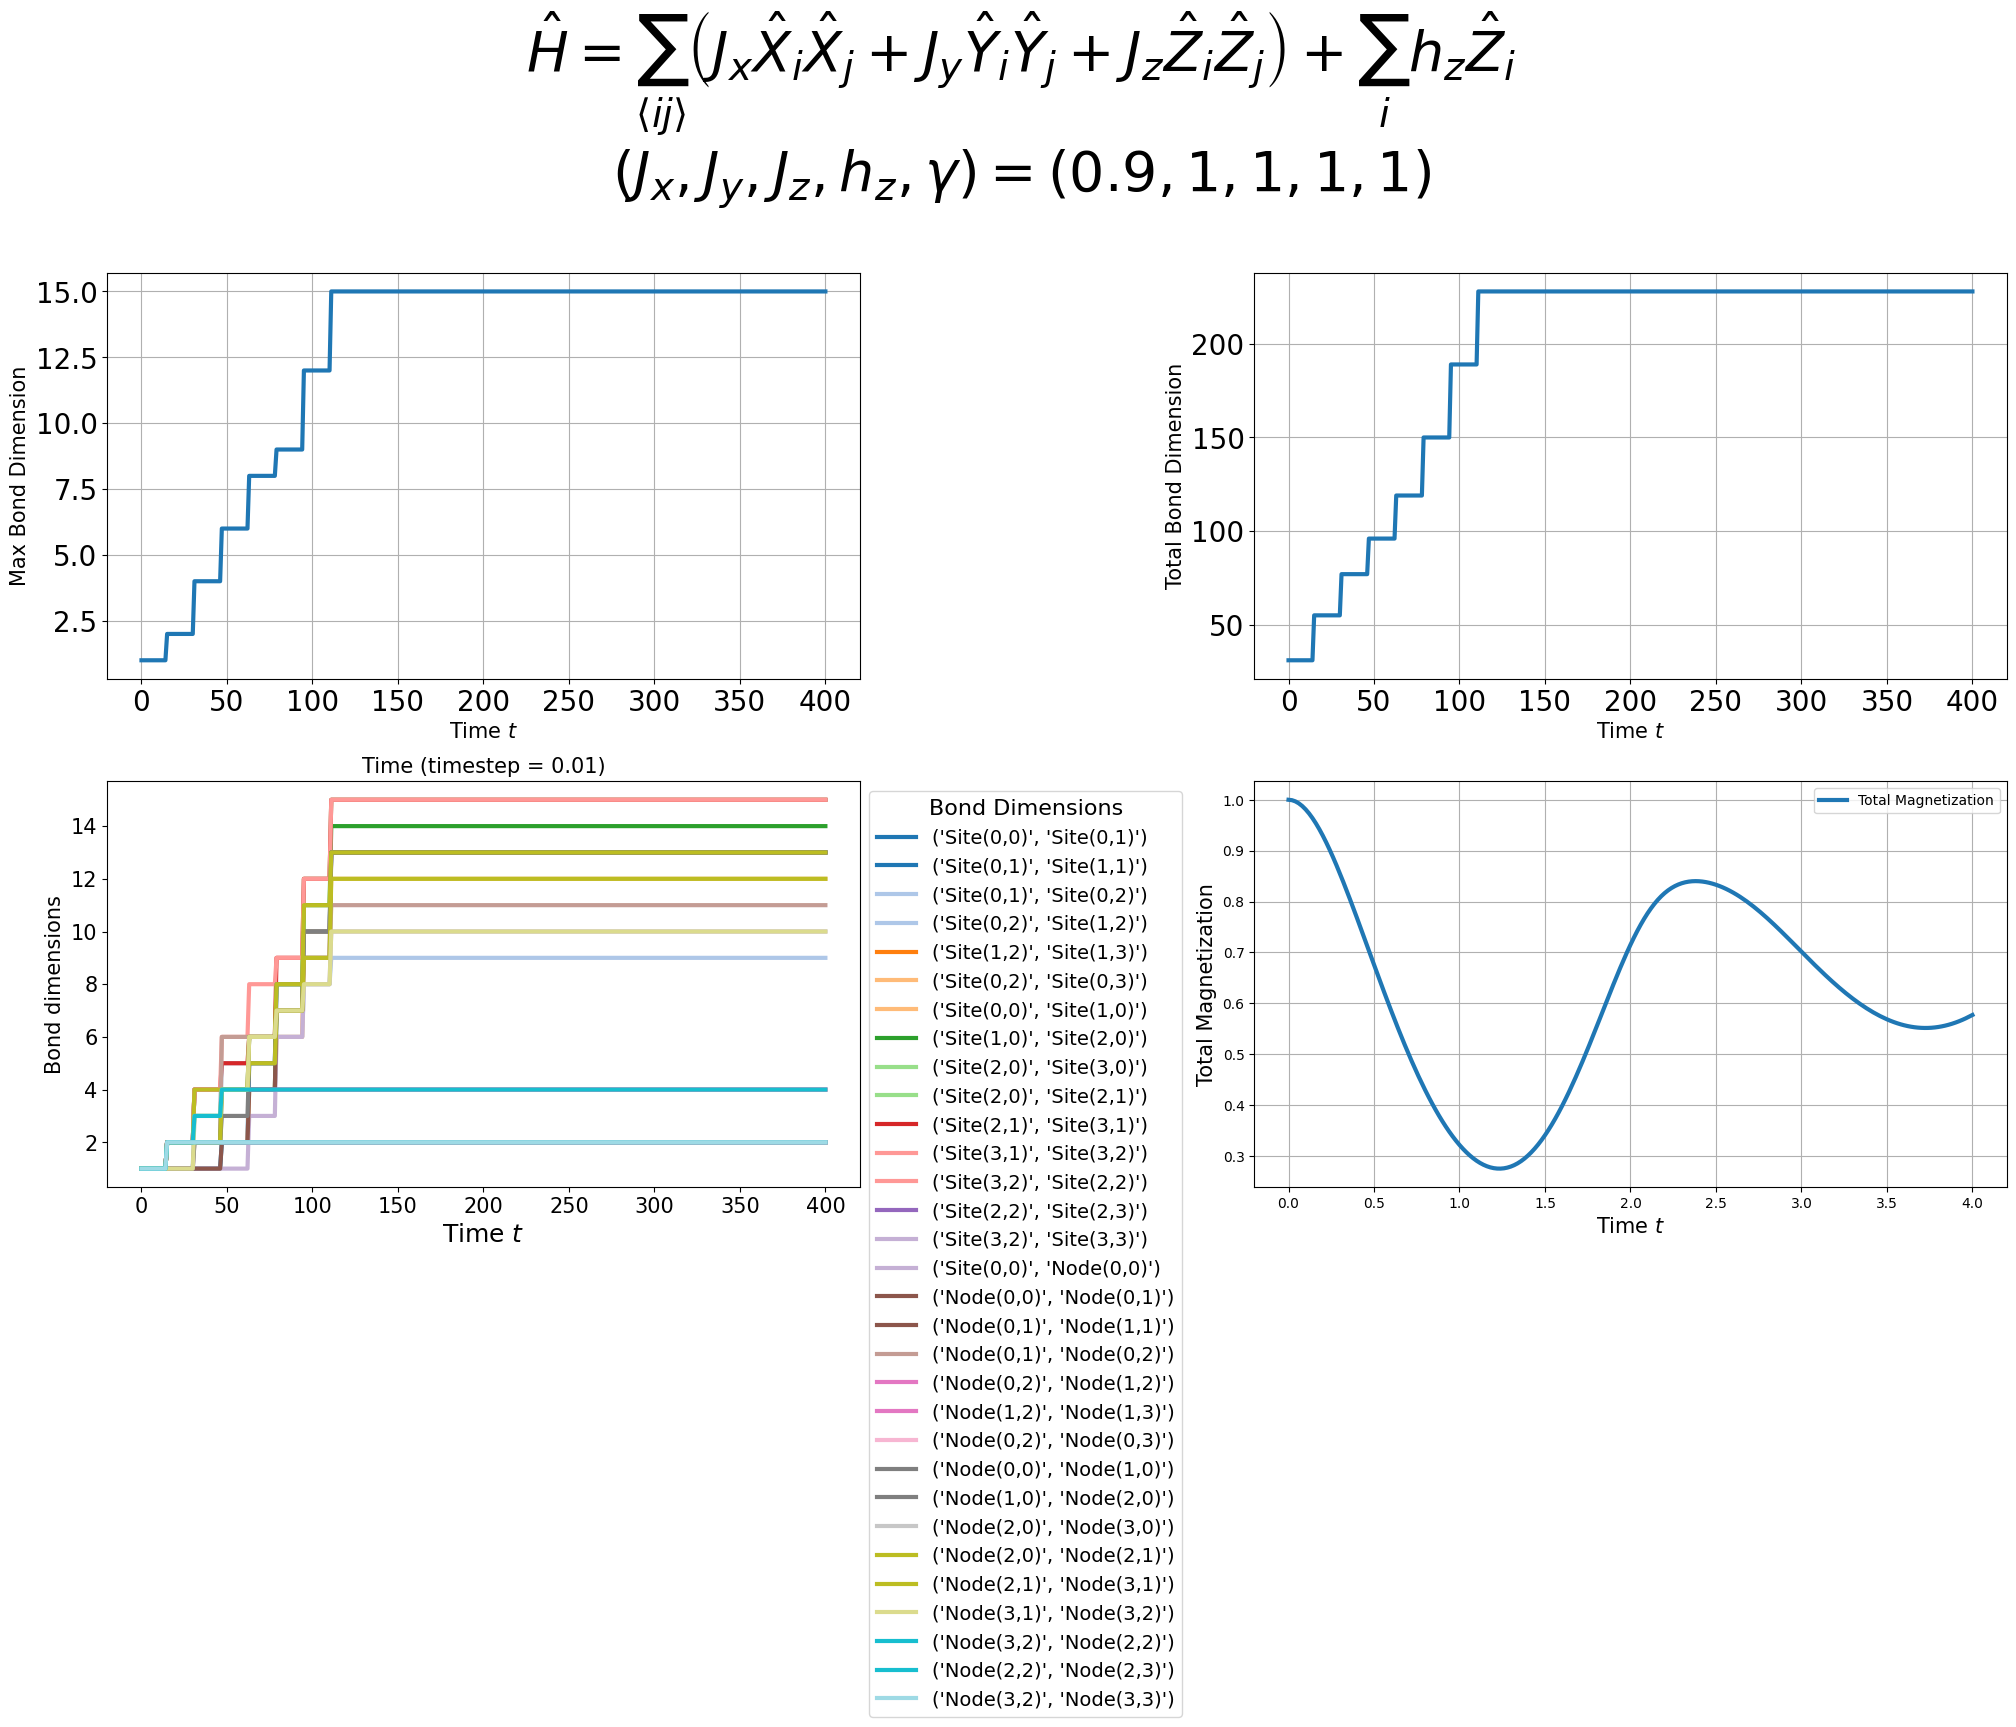

In [54]:
import matplotlib.pyplot as plt

def get_distinct_colors(n):
    """Generates a list of n distinct, visually appealing colors using colormap cyclically."""
    from matplotlib.cm import get_cmap
    cmap = get_cmap('tab20')  # Choose a colormap with more distinct colors
    return [cmap(i / n) for i in range(n)]

# Create a figure with a grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

# Set a title for the entire figure
plt.suptitle(r'$\hat{H}=\sum_{\langle i j\rangle}\left(J_x \hat{X}_i \hat{X}_j+J_y \hat{Y}_i \hat{Y}_j+J_z \hat{Z}_i \hat{Z}_j\right)+\sum_i h_z \hat{Z}_i$' + '\n' + 
             r'$(J_x,J_y,J_z,h_z,\gamma) = (0.9, 1, 1, 1, 1) $', 
             fontsize=40, y=0.98)
# Plot max bond dimension
axs[0, 0].plot(tdvp_ex1.max_bond_dim, linewidth=3)
axs[0, 0].set_xlabel("Time $t$", fontsize=15)
axs[0, 0].set_ylabel('Max Bond Dimension', fontsize=15)
axs[0, 0].tick_params(axis='both', which='major', labelsize=20)
axs[0, 0].grid(True)

# Plot total bond dimension
axs[0, 1].plot(tdvp_ex1.total_bond_dim, linewidth=3)
axs[0, 1].set_xlabel("Time $t$", fontsize=15)
axs[0, 1].set_ylabel('Total Bond Dimension', fontsize=15)
axs[0, 1].tick_params(axis='both', which='major', labelsize=20)
axs[0, 1].grid(True)

# Plot bond dimensions for each key
colors = get_distinct_colors(len(tdvp_ex1.bond_dims))
for i, (key, values) in enumerate(tdvp_ex1.bond_dims.items()):
    x = list(range(len(values)))
    axs[1, 0].plot(x, values, label=key, color=colors[i], linewidth=3)
axs[1, 0].legend(title='Bond Dimensions', loc='upper left', bbox_to_anchor=(1, 1), fontsize=14, title_fontsize=16)
axs[1, 0].set_xlabel("Time $t$", fontsize=18)
axs[1, 0].set_ylabel('Bond dimensions', fontsize=15)
axs[1, 0].set_title('Time (timestep = 0.01)', fontsize=15)
axs[1, 0].tick_params(axis='both', which='major', labelsize=15)
plt.subplots_adjust(right=0.8)

# Plot results_M
axs[1, 1].plot(times , results_M, label="Total Magnetization", linewidth=3)
axs[1, 1].set_xlabel("Time $t$", fontsize=15)
axs[1, 1].set_ylabel("Total Magnetization", fontsize=15)
axs[1, 1].grid(True)
axs[1, 1].legend()

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title

# Show the plot
plt.show()


C:\Users\edpou\AppData\Local\Temp\ipykernel_3544\3009601564.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')  # Choose a colormap with more distinct colors


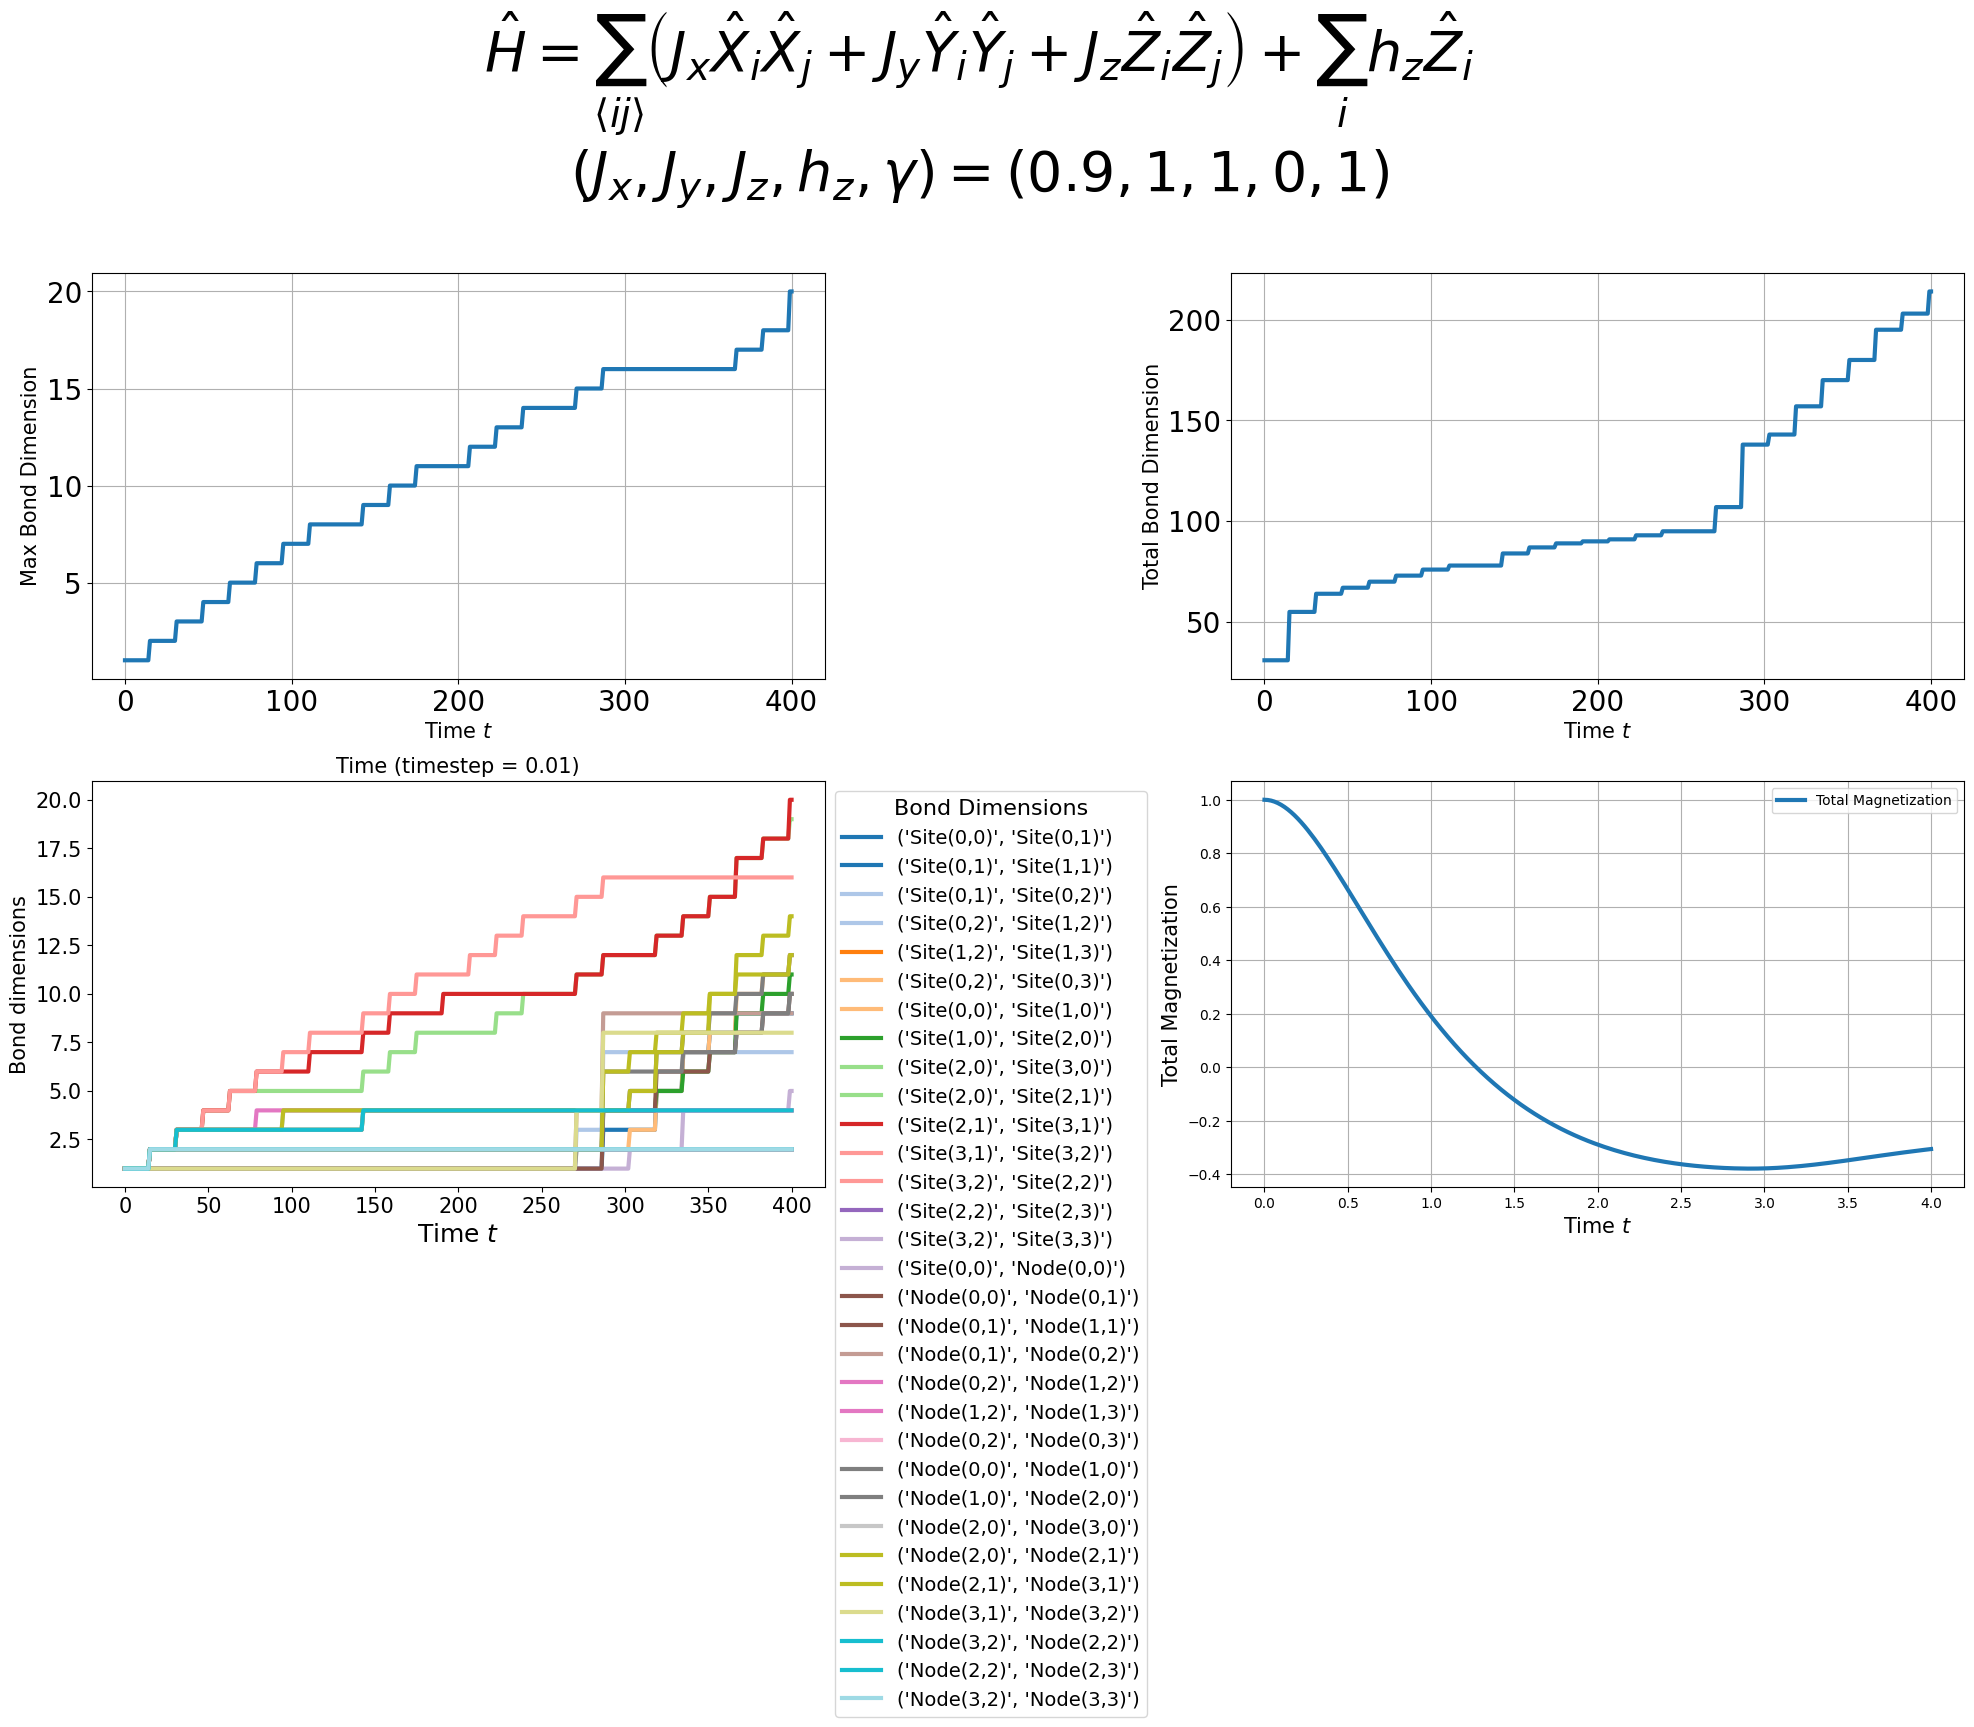

In [17]:
import matplotlib.pyplot as plt

def get_distinct_colors(n):
    """Generates a list of n distinct, visually appealing colors using colormap cyclically."""
    from matplotlib.cm import get_cmap
    cmap = get_cmap('tab20')  # Choose a colormap with more distinct colors
    return [cmap(i / n) for i in range(n)]

# Create a figure with a grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

# Set a title for the entire figure
plt.suptitle(r'$\hat{H}=\sum_{\langle i j\rangle}\left(J_x \hat{X}_i \hat{X}_j+J_y \hat{Y}_i \hat{Y}_j+J_z \hat{Z}_i \hat{Z}_j\right)+\sum_i h_z \hat{Z}_i$' + '\n' + 
             r'$(J_x,J_y,J_z,h_z,\gamma) = (0.9, 1, 1, 0, 1) $', 
             fontsize=40, y=0.98)
# Plot max bond dimension
axs[0, 0].plot(tdvp_ex1.max_bond_dim, linewidth=3)
axs[0, 0].set_xlabel("Time $t$", fontsize=15)
axs[0, 0].set_ylabel('Max Bond Dimension', fontsize=15)
axs[0, 0].tick_params(axis='both', which='major', labelsize=20)
axs[0, 0].grid(True)

# Plot total bond dimension
axs[0, 1].plot(tdvp_ex1.total_bond_dim, linewidth=3)
axs[0, 1].set_xlabel("Time $t$", fontsize=15)
axs[0, 1].set_ylabel('Total Bond Dimension', fontsize=15)
axs[0, 1].tick_params(axis='both', which='major', labelsize=20)
axs[0, 1].grid(True)

# Plot bond dimensions for each key
colors = get_distinct_colors(len(tdvp_ex1.bond_dims))
for i, (key, values) in enumerate(tdvp_ex1.bond_dims.items()):
    x = list(range(len(values)))
    axs[1, 0].plot(x, values, label=key, color=colors[i], linewidth=3)
axs[1, 0].legend(title='Bond Dimensions', loc='upper left', bbox_to_anchor=(1, 1), fontsize=14, title_fontsize=16)
axs[1, 0].set_xlabel("Time $t$", fontsize=18)
axs[1, 0].set_ylabel('Bond dimensions', fontsize=15)
axs[1, 0].set_title('Time (timestep = 0.01)', fontsize=15)
axs[1, 0].tick_params(axis='both', which='major', labelsize=15)
plt.subplots_adjust(right=0.8)

# Plot results_M
axs[1, 1].plot(times , results_M, label="Total Magnetization", linewidth=3)
axs[1, 1].set_xlabel("Time $t$", fontsize=15)
axs[1, 1].set_ylabel("Total Magnetization", fontsize=15)
axs[1, 1].grid(True)
axs[1, 1].legend()

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title

# Show the plot
plt.show()


C:\Users\edpou\AppData\Local\Temp\ipykernel_3544\3009601564.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')  # Choose a colormap with more distinct colors
c:\Users\edpou\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\edpou\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


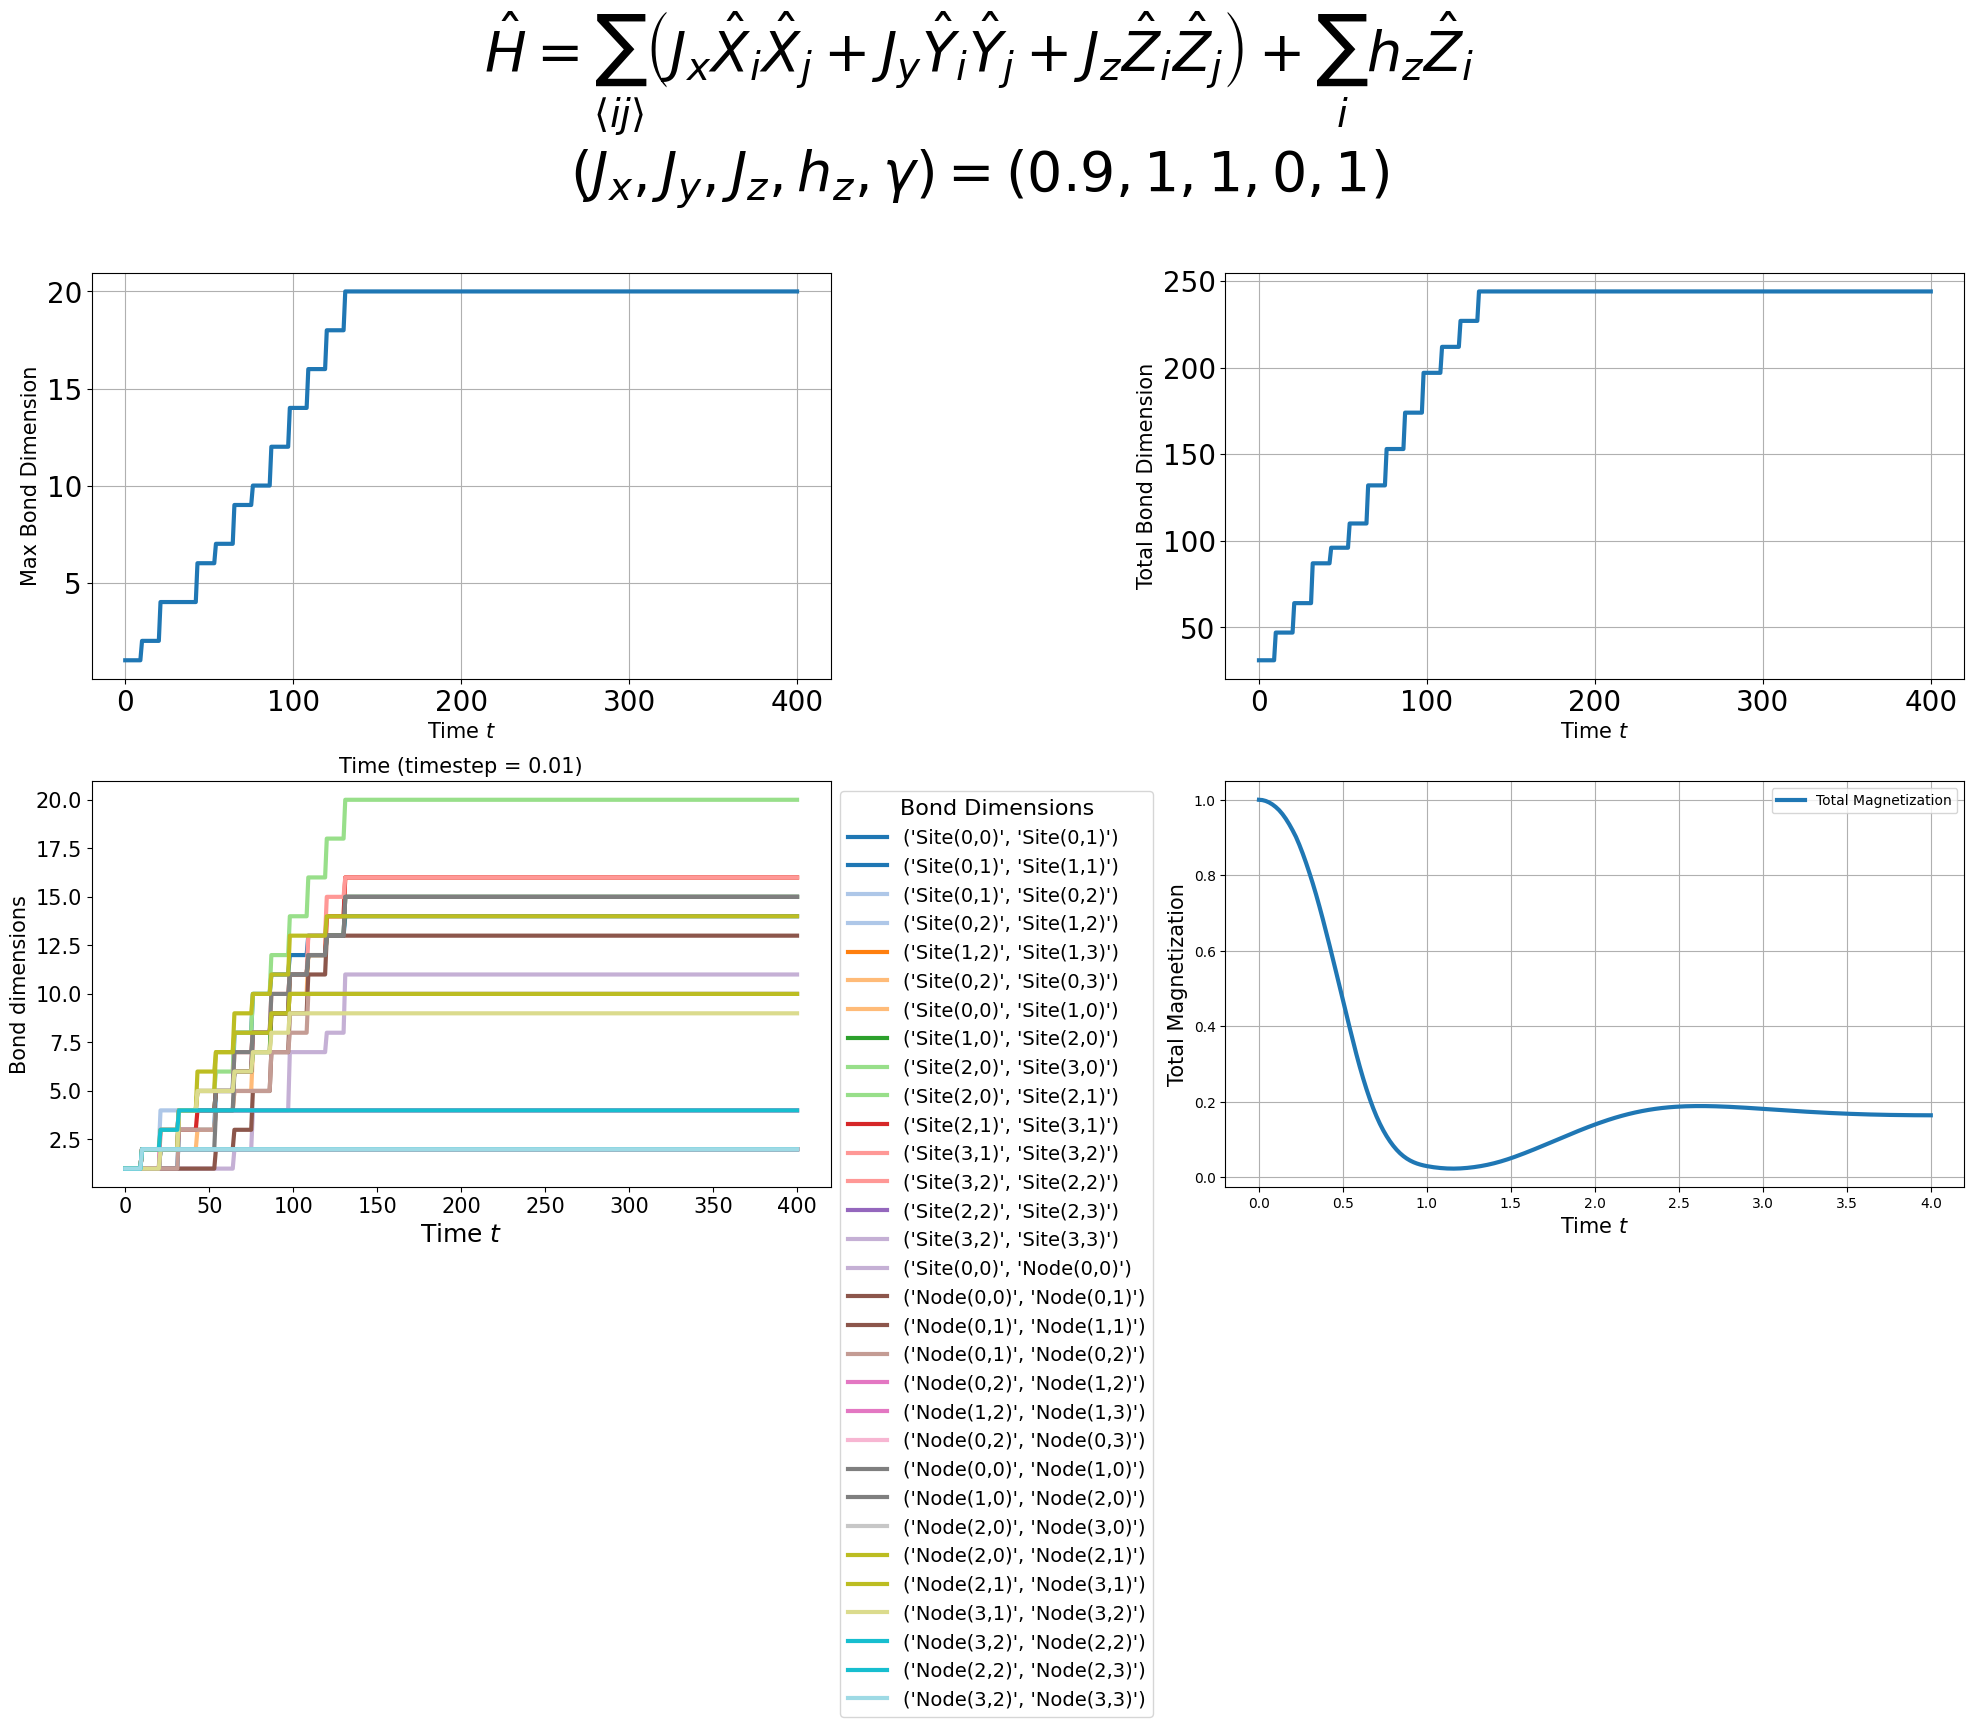

In [137]:
import matplotlib.pyplot as plt

def get_distinct_colors(n):
    """Generates a list of n distinct, visually appealing colors using colormap cyclically."""
    from matplotlib.cm import get_cmap
    cmap = get_cmap('tab20')  # Choose a colormap with more distinct colors
    return [cmap(i / n) for i in range(n)]

# Create a figure with a grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

# Set a title for the entire figure
plt.suptitle(r'$\hat{H}=\sum_{\langle i j\rangle}\left(J_x \hat{X}_i \hat{X}_j+J_y \hat{Y}_i \hat{Y}_j+J_z \hat{Z}_i \hat{Z}_j\right)+\sum_i h_z \hat{Z}_i$' + '\n' + 
             r'$(J_x,J_y,J_z,h_z,\gamma) = (0.9, 1, 1, 0, 1) $', 
             fontsize=40, y=0.98)
# Plot max bond dimension
axs[0, 0].plot(tdvp_ex1.max_bond_dim, linewidth=3)
axs[0, 0].set_xlabel("Time $t$", fontsize=15)
axs[0, 0].set_ylabel('Max Bond Dimension', fontsize=15)
axs[0, 0].tick_params(axis='both', which='major', labelsize=20)
axs[0, 0].grid(True)

# Plot total bond dimension
axs[0, 1].plot(tdvp_ex1.total_bond_dim, linewidth=3)
axs[0, 1].set_xlabel("Time $t$", fontsize=15)
axs[0, 1].set_ylabel('Total Bond Dimension', fontsize=15)
axs[0, 1].tick_params(axis='both', which='major', labelsize=20)
axs[0, 1].grid(True)

# Plot bond dimensions for each key
colors = get_distinct_colors(len(tdvp_ex1.bond_dims))
for i, (key, values) in enumerate(tdvp_ex1.bond_dims.items()):
    x = list(range(len(values)))
    axs[1, 0].plot(x, values, label=key, color=colors[i], linewidth=3)
axs[1, 0].legend(title='Bond Dimensions', loc='upper left', bbox_to_anchor=(1, 1), fontsize=14, title_fontsize=16)
axs[1, 0].set_xlabel("Time $t$", fontsize=18)
axs[1, 0].set_ylabel('Bond dimensions', fontsize=15)
axs[1, 0].set_title('Time (timestep = 0.01)', fontsize=15)
axs[1, 0].tick_params(axis='both', which='major', labelsize=15)
plt.subplots_adjust(right=0.8)

# Plot results_M
axs[1, 1].plot(times , results_M, label="Total Magnetization", linewidth=3)
axs[1, 1].set_xlabel("Time $t$", fontsize=15)
axs[1, 1].set_ylabel("Total Magnetization", fontsize=15)
axs[1, 1].grid(True)
axs[1, 1].legend()

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title

# Show the plot
plt.show()


In [221]:
results_18 = np.array([1.        +0.00000000e+00j, 0.99920718+1.32032738e-10j,
       0.9968569 +1.03498344e-09j, 0.99298589+3.41196696e-09j,
       0.98762388+7.87176704e-09j, 0.98079426+1.49104652e-08j,
       0.97241793-2.23892625e-06j, 0.96196831-2.24858146e-05j,
       0.9494957 -6.55213759e-05j, 0.93518661-1.27478358e-04j,
       0.91924123-1.98132845e-04j, 0.90185282-2.63848472e-04j,
       0.88110016-5.74046754e-04j, 0.85816606-9.20833781e-04j,
       0.83333518-1.28832542e-03j, 0.80681674-1.66283407e-03j,
       0.77876492-2.02584918e-03j, 0.74892665-2.32514888e-03j,
       0.71719006-2.46143901e-03j, 0.68405334-2.45189255e-03j,
       0.64976356-2.34401998e-03j, 0.61455641-2.20944579e-03j,
       0.57865785-2.12725015e-03j, 0.54221679-2.20961941e-03j,
       0.50553263-2.43966320e-03j, 0.46881165-2.80248345e-03j,
       0.4322736 -3.23882515e-03j, 0.39613175-3.64234679e-03j,
       0.3603735 -3.37501407e-03j, 0.32582114-2.12860965e-03j,
       0.2930427 -2.80120120e-04j, 0.26228319+2.15050222e-03j,
       0.2336825 +5.07918700e-03j, 0.20728811+8.36305312e-03j,
       0.18301245+1.18738627e-02j, 0.16118556+1.54825444e-02j,
       0.14168095+1.89859096e-02j, 0.12433157+2.22034999e-02j,
       0.10895259+2.49905436e-02j, 0.0953187 +2.72781148e-02j,
       0.08323606+2.90488320e-02j, 0.07272119+3.02896023e-02j,
       0.06368418+3.10432066e-02j, 0.05602425+3.13669143e-02j,
       0.04962656+3.13272516e-02j, 0.04432246+3.10200182e-02j,
       0.04000723+3.04741525e-02j, 0.03652186+2.97556872e-02j,
       0.03371303+2.89060769e-02j, 0.03143541+2.79544406e-02j,
       0.02955707+2.69360611e-02j, 0.02798615+2.58748478e-02j,
       0.02665482+2.47492456e-02j, 0.02552562+2.35589260e-02j,
       0.02458847+2.23076436e-02j, 0.02385055+2.10003523e-02j,
       0.02333088+1.96622256e-02j, 0.02304076+1.82703844e-02j,
       0.02298426+1.68264165e-02j, 0.02315442+1.53351294e-02j,
       0.0235371 +1.38018995e-02j, 0.02411873+1.22410229e-02j,
       0.02488562+1.06595959e-02j, 0.02582229+9.06467446e-03j,
       0.02692361+7.47128714e-03j, 0.02819044+5.89284261e-03j,
       0.02962779+4.34122759e-03j, 0.03124864+2.83263489e-03j,
       0.03305211+1.37177548e-03j, 0.03503709-3.69440727e-05j,
       0.03720398-1.38800848e-03j, 0.0395506 -2.67570225e-03j,
       0.04207185-3.89463844e-03j, 0.04475956-5.04033851e-03j,
       0.04760262-6.10927586e-03j, 0.05058788-7.09863412e-03j,
       0.05370118-8.00626476e-03j, 0.05692759-8.83077724e-03j,
       0.06025181-9.57140555e-03j, 0.06365923-1.02278120e-02j,
       0.06713672-1.08001753e-02j, 0.07067294-1.12892471e-02j,
       0.07425851-1.16961814e-02j, 0.07788589-1.20225015e-02j,
       0.08154895-1.22703811e-02j, 0.08524234-1.24430198e-02j,
       0.08896102-1.25448201e-02j, 0.09269985-1.25812325e-02j,
       0.0964531 -1.25583549e-02j, 0.10021405-1.24824974e-02j,
       0.10397494-1.23597883e-02j, 0.10772723-1.21957083e-02j,
       0.11146203-1.19946205e-02j, 0.11517036-1.17596415e-02j,
       0.11884343-1.14930114e-02j, 0.12247287-1.11967257e-02j,
       0.12605088-1.08730764e-02j, 0.12957024-1.05249220e-02j,
       0.13302439-1.01556874e-02j, 0.13640732-9.76916363e-03j,
       0.13971354-9.36920023e-03j, 0.14293788-8.95939282e-03j,
       0.14607535-8.54285060e-03j, 0.14912099-8.12209655e-03j,
       0.15206984-7.69911326e-03j, 0.15491705-7.27550963e-03j,
       0.15765798-6.85275209e-03j, 0.16028837-6.43238227e-03j,
       0.16280445-6.01614549e-03j, 0.16520304-5.60598625e-03j,
       0.16748159-5.20391733e-03j, 0.16963829-4.81181311e-03j,
       0.17167203-4.43119558e-03j, 0.17358234-4.06307706e-03j,
       0.17536931-3.70790469e-03j, 0.17703342-3.36562137e-03j,
       0.17857548-3.03582145e-03j, 0.17999657-2.71795194e-03j,
       0.18129812-2.41149934e-03j, 0.1824819 -2.11611047e-03j,
       0.18355008-1.83162301e-03j, 0.18450528-1.55801654e-03j,
       0.18535057-1.29532256e-03j, 0.18608946-1.04354101e-03j,
       0.18672585-8.02599992e-04j, 0.18726399-5.72371509e-04j,
       0.18770842-3.52728706e-04j, 0.18806387-1.43613548e-04j,
       0.18833514+5.49162030e-05j, 0.18852705+2.42679139e-04j,
       0.18864435+4.19403630e-04j, 0.18869161+5.84791634e-04j,
       0.18867322+7.38594281e-04j, 0.18859336+8.80678303e-04j,
       0.188456  +1.01106566e-03j, 0.18826496+1.12993756e-03j,
       0.18802394+1.23760581e-03j, 0.18773656+1.33446478e-03j,
       0.18740643+1.42094153e-03j, 0.18703713+1.49745960e-03j,
       0.18663218+1.56442450e-03j, 0.18619509+1.62223051e-03j,
       0.18572922+1.67128070e-03j, 0.18523781+1.71200859e-03j,
       0.18472391+1.74489033e-03j, 0.1841904 +1.77044091e-03j,
       0.18363998+1.78919491e-03j, 0.1830752 +1.80167765e-03j,
       0.18249848+1.80837654e-03j, 0.18191215+1.80972105e-03j,
       0.18131844+1.80607639e-03j, 0.18071953+1.79775066e-03j,
       0.18011746+1.78501093e-03j, 0.17951422+1.76810105e-03j,
       0.17891164+1.74725459e-03j, 0.17831142+1.72269877e-03j,
       0.17771513+1.69464894e-03j, 0.17712416+1.66329712e-03j,
       0.17653981+1.62880013e-03j, 0.17596324+1.59127299e-03j,
       0.17539551+1.55079146e-03j, 0.17483759+1.50740453e-03j,
       0.17429038+1.46115431e-03j, 0.17375467+1.41209838e-03j,
       0.17323122+1.36032918e-03j, 0.17272066+1.30598554e-03j,
       0.17222358+1.24925446e-03j, 0.17174049+1.19036349e-03j,
       0.1712718 +1.12956689e-03j, 0.17081789+1.06713010e-03j,
       0.17037909+1.00331656e-03j, 0.16995567+9.38380164e-04j,
       0.16954787+8.72564192e-04j, 0.16915589+8.06105725e-04j,
       0.1687799 +7.39242979e-04j, 0.16842   +6.72222482e-04j,
       0.16807628+6.05303430e-04j, 0.16774875+5.38757670e-04j,
       0.16743741+4.72865206e-04j, 0.16714217+4.07906407e-04j,
       0.16686293+3.44152879e-04j, 0.16659952+2.81859090e-04j,
       0.16635178+2.21256365e-04j, 0.16611947+1.62549973e-04j,
       0.16590236+1.05919139e-04j, 0.16570018+5.15191001e-05j,
       0.16551265-5.15933138e-07j, 0.16533947-5.00699583e-05j,
       0.1651803 -9.70431033e-05j, 0.16503483-1.41350431e-04j,
       0.1649027 -1.82921375e-04j, 0.16478355-2.21699385e-04j,
       0.16467703-2.57641448e-04j, 0.16458274-2.90717327e-04j,
       0.16450032-3.20908664e-04j, 0.16442937-3.48208217e-04j,
       0.16436947-3.72619546e-04j, 0.16432023-3.94157318e-04j,
       0.1642812 -4.12848153e-04j, 0.16425196-4.28731694e-04j,
       0.16423207-4.41861436e-04j])

In [207]:
results_1 = np.array([ 1.        +0.00000000e+00j,  0.99920786+7.31825638e-11j,
        0.99686596+5.73285638e-10j,  0.99302951+1.88889389e-09j,
        0.98775773+4.35532118e-09j,  0.98111316+8.24458513e-09j,
        0.97316108+1.37588499e-08j,  0.96396884+2.10272605e-08j,
        0.95360533+3.01059135e-08j,  0.94213221+1.20697205e-06j,
        0.9296151 +5.05512434e-06j,  0.91613302+1.20571203e-05j,
        0.9017647 +2.27043687e-05j,  0.88658709+3.75188661e-05j,
        0.87067434+5.70628850e-05j,  0.8540971 +8.19132582e-05j,
        0.83692223+1.12600107e-04j,  0.81921128+1.50150530e-04j,
        0.8010209 +1.95538552e-04j,  0.78240848+2.48507785e-04j,
        0.76342743+3.08499142e-04j,  0.7441277 +3.74660357e-04j,
        0.72455604+4.45867258e-04j,  0.70475629+5.20755229e-04j,
        0.68476968+5.97762552e-04j,  0.66463507+6.75063821e-04j,
        0.64438894+7.50918616e-04j,  0.62406612+8.23549525e-04j,
        0.60369959+8.91240854e-04j,  0.58332061+9.52390510e-04j,
        0.56295873+1.00555911e-03j,  0.54264184+1.04950838e-03j,
        0.52239618+1.08322917e-03j,  0.50224636+1.10594958e-03j,
        0.48221503+1.11715043e-03j,  0.46232348+1.11667998e-03j,
        0.44259134+1.10467294e-03j,  0.42303668+1.08152578e-03j,
        0.40367608+1.04786187e-03j,  0.38452464+1.00449159e-03j,
        0.36559606+9.52371392e-04j,  0.34690268+8.92563514e-04j,
        0.32845551+8.26201801e-04j,  0.31026429+7.54455510e-04j,
        0.29233755+6.78503771e-04j,  0.27468265+5.99512206e-04j,
        0.25730585+5.18627374e-04j,  0.24021237+4.36944196e-04j,
        0.22340644+3.55500523e-04j,  0.20689139+2.75264846e-04j,
        0.19066974+1.97127381e-04j,  0.17474323+1.21886735e-04j,
        0.15911292+5.02427758e-05j,  0.14377925-1.72089396e-05j,
        0.12874209-7.99794976e-05j,  0.11400082-1.37686121e-04j,
        0.09955436-1.90048674e-04j,  0.08540123-2.36883973e-04j,
        0.0715396 -2.78100360e-04j,  0.05796734-3.13689482e-04j,
        0.04468206-3.43719791e-04j,  0.03168112-3.68329761e-04j,
        0.01896173-3.87721414e-04j,  0.0065209 -4.02153857e-04j,
       -0.00564445-4.11936496e-04j, -0.01753752-4.17421685e-04j,
       -0.02916159-4.18996658e-04j, -0.04052   -4.17074626e-04j,
       -0.05161612-4.12085270e-04j, -0.06245336-4.04465298e-04j,
       -0.07303514-3.94649440e-04j, -0.08336489-3.83062168e-04j,
       -0.09344607-3.70110468e-04j, -0.10328212-3.56177830e-04j,
       -0.11287649-3.41619475e-04j, -0.12223265-3.26759084e-04j,
       -0.13135407-3.11886319e-04j, -0.14024425-2.97255357e-04j,
       -0.14890672-2.83084364e-04j, -0.15734501-2.69555814e-04j,
       -0.16556271-2.56817652e-04j, -0.17356341-2.44985396e-04j,
       -0.18135075-2.34145081e-04j, -0.18892838-2.24357013e-04j,
       -0.19629997-2.15660124e-04j, -0.20346921-2.08076684e-04j,
       -0.2104398 -2.01617103e-04j, -0.21721545-1.96284507e-04j,
       -0.22379984-1.92078855e-04j, -0.23019667-1.89000456e-04j,
       -0.23640961-1.87052760e-04j, -0.24244232-1.86244534e-04j,
       -0.24829842-1.86591435e-04j, -0.25398148-1.88117132e-04j,
       -0.25949505-1.90854064e-04j, -0.26484263-1.94843889e-04j,
       -0.27002762-2.00137638e-04j, -0.2750534 -2.06795503e-04j,
       -0.27992326-2.14886225e-04j, -0.28464042-2.24485959e-04j,
       -0.28920801-2.35676637e-04j, -0.2936291 -2.48543848e-04j,
       -0.29790667-2.63174362e-04j, -0.30204363-2.79653487e-04j,
       -0.3060428 -2.98062472e-04j, -0.30990695-3.18476195e-04j,
       -0.31363876-3.40961321e-04j, -0.31724083-3.65575064e-04j,
       -0.32071572-3.92364565e-04j, -0.32406592-4.21366858e-04j,
       -0.32729385-4.52609269e-04j, -0.33040189-4.86110105e-04j,
       -0.33339237-5.21879443e-04j, -0.33626755-5.59919869e-04j,
       -0.33902968-6.00227087e-04j, -0.34168093-6.42790324e-04j,
       -0.34422347-6.87592593e-04j, -0.34665941-7.34610845e-04j,
       -0.34899083-7.83816087e-04j, -0.35121976-8.35173559e-04j,
       -0.35334823-8.88642990e-04j, -0.35537821-9.44178958e-04j,
       -0.35731164-1.00173132e-03j, -0.35915046-1.06124566e-03j,
       -0.36089655-1.12266370e-03j, -0.36255177-1.18592359e-03j,
       -0.36411797-1.25096017e-03j, -0.36559696-1.31770500e-03j,
       -0.36699054-1.38608641e-03j, -0.36830048-1.45602945e-03j,
       -0.36952852-1.52745594e-03j, -0.37067638-1.60028456e-03j,
       -0.37174579-1.67443108e-03j, -0.37273841-1.74980875e-03j,
       -0.3736559 -1.82632878e-03j, -0.37449991-1.90390096e-03j,
       -0.37527206-1.98243415e-03j, -0.37596886-2.06111705e-03j,
       -0.37658944-2.13568829e-03j, -0.37713583-2.20608135e-03j,
       -0.37761002-2.27226007e-03j, -0.37801399-2.33421041e-03j,
       -0.37834968-2.39193589e-03j, -0.37861901-2.44545271e-03j,
       -0.37882389-2.49478669e-03j, -0.3789515 -2.54434770e-03j,
       -0.37898772-2.59086421e-03j, -0.37893274-2.63496974e-03j,
       -0.37878691-2.67682600e-03j, -0.37855102-2.71628788e-03j,
       -0.37822626-2.75308930e-03j, -0.37781414-2.78695238e-03j,
       -0.37731639-2.81763088e-03j, -0.37673478-2.84489286e-03j,
       -0.3760713 -2.86847985e-03j, -0.37532819-2.88832869e-03j,
       -0.37450779-2.90433315e-03j, -0.37361257-2.91639808e-03j,
       -0.3726451 -2.92443722e-03j, -0.37160804-2.92837571e-03j,
       -0.37050416-2.92815490e-03j, -0.36933618-2.92358020e-03j,
       -0.36810695-2.91474845e-03j, -0.36681945-2.90171424e-03j,
       -0.36547676-2.88454962e-03j, -0.36408201-2.86333813e-03j,
       -0.36263841-2.83816745e-03j, -0.36114922-2.80912433e-03j,
       -0.35961774-2.77629353e-03j, -0.35804716-2.73969116e-03j,
       -0.35644079-2.69945033e-03j, -0.35480193-2.65567041e-03j,
       -0.35313385-2.60846766e-03j, -0.35143983-2.55798111e-03j,
       -0.34972309-2.50437489e-03j, -0.34798681-2.44783726e-03j,
       -0.34623415-2.38857686e-03j, -0.34446817-2.32679771e-03j,
       -0.34269188-2.26273743e-03j, -0.34090823-2.19663950e-03j,
       -0.33912011-2.12874034e-03j, -0.33733031-2.05926617e-03j,
       -0.33554151-1.98843236e-03j, -0.33375627-1.91644396e-03j,
       -0.33197705-1.84349582e-03j, -0.33020607-1.76976202e-03j,
       -0.32844544-1.69541312e-03j, -0.32669722-1.62063928e-03j,
       -0.32496339-1.54561462e-03j, -0.32324578-1.47049281e-03j,
       -0.32154613-1.39540835e-03j, -0.31986602-1.32048280e-03j,
       -0.3182069 -1.24583401e-03j, -0.31657006-1.17159729e-03j,
       -0.31495662-1.09787423e-03j, -0.31336763-1.02478071e-03j,
       -0.311804  -9.52449289e-04j, -0.31026656-8.81020717e-04j,
       -0.30875603-8.10630118e-04j, -0.30727302-7.41391069e-04j,
       -0.30581804-6.73382404e-04j])

c:\Users\edpou\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\edpou\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


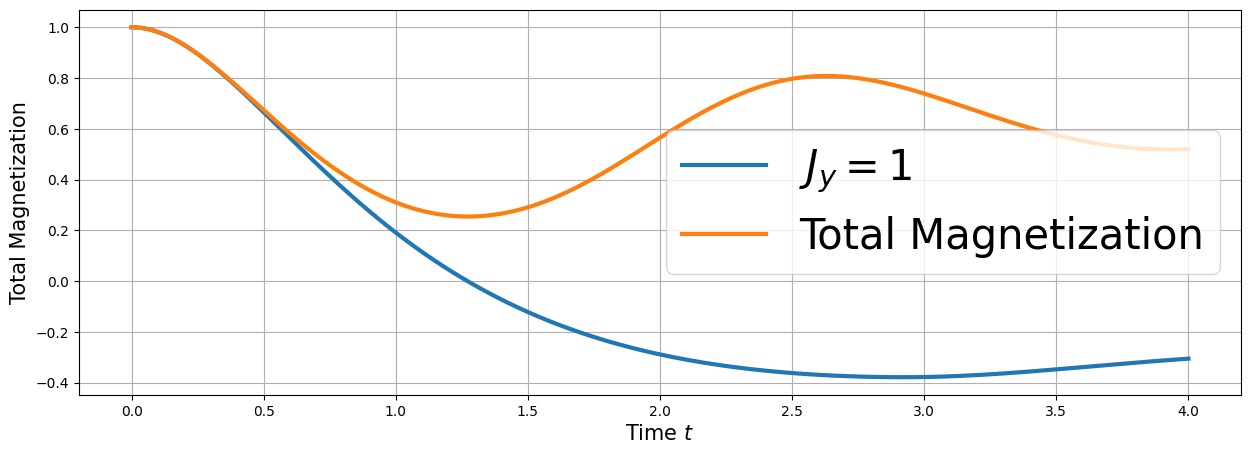

In [208]:
import matplotlib.pyplot as plt

fig1, axs1 = plt.subplots(1, 1, sharex=True, figsize=(15, 5))

axs1.plot(times, results_1, label="$J_y = 1$", linewidth=3)
#axs1.plot(times, results_18, label="$J_y = 1.8$", linewidth=3)
axs1.plot(times, results_M, label="Total Magnetization", linewidth=3)

axs1.set_xlabel("Time $t$", fontsize=15)
axs1.set_ylabel("Total Magnetization", fontsize=15)
axs1.grid(True)
axs1.legend(fontsize=30)  # Increased font size for the legend

In [ ]:
import matplotlib.pyplot as plt

def get_distinct_colors(n):
    """Generates a list of n distinct, visually appealing colors using colormap cyclically."""
    from matplotlib.cm import get_cmap
    cmap = get_cmap('tab20')  # Choose a colormap with more distinct colors
    return [cmap(i / n) for i in range(n)]

# Create a figure with a grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

# Set a title for the entire figure
plt.suptitle(r'$\hat{H}=\sum_{\langle i j\rangle}\left(J_x \hat{X}_i \hat{X}_j+J_y \hat{Y}_i \hat{Y}_j+J_z \hat{Z}_i \hat{Z}_j\right)+\sum_i h_z \hat{Z}_i$' + '\n' + 
             r'$(J_x,J_y,J_z,h_z,\gamma) = (0.9, 1, 1, 0, 1) $', 
             fontsize=40, y=0.98)
# Plot max bond dimension
axs[0, 0].plot(tdvp_ex1.max_bond_dim, linewidth=3)
axs[0, 0].set_xlabel("Time $t$", fontsize=15)
axs[0, 0].set_ylabel('Max Bond Dimension', fontsize=15)
axs[0, 0].tick_params(axis='both', which='major', labelsize=20)
axs[0, 0].grid(True)

# Plot total bond dimension
axs[0, 1].plot(tdvp_ex1.total_bond_dim, linewidth=3)
axs[0, 1].set_xlabel("Time $t$", fontsize=15)
axs[0, 1].set_ylabel('Total Bond Dimension', fontsize=15)
axs[0, 1].tick_params(axis='both', which='major', labelsize=20)
axs[0, 1].grid(True)

# Plot bond dimensions for each key
colors = get_distinct_colors(len(tdvp_ex1.bond_dims))
for i, (key, values) in enumerate(tdvp_ex1.bond_dims.items()):
    x = list(range(len(values)))
    axs[1, 0].plot(x, values, label=key, color=colors[i], linewidth=3)
axs[1, 0].legend(title='Bond Dimensions', loc='upper left', bbox_to_anchor=(1, 1), fontsize=14, title_fontsize=16)
axs[1, 0].set_xlabel("Time $t$", fontsize=18)
axs[1, 0].set_ylabel('Bond dimensions', fontsize=15)
axs[1, 0].set_title('Time (timestep = 0.01)', fontsize=15)
axs[1, 0].tick_params(axis='both', which='major', labelsize=15)
plt.subplots_adjust(right=0.8)

# Plot results_M
axs[1, 1].plot(times , results_M, label="Total Magnetization", linewidth=3)
axs[1, 1].set_xlabel("Time $t$", fontsize=15)
axs[1, 1].set_ylabel("Total Magnetization", fontsize=15)
axs[1, 1].grid(True)
axs[1, 1].legend()

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title

# Show the plot
plt.show()
